**Imports**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
from numpy import pi
import numpy as np
from thesis.main import main, rollout
from thesis.util import animate
from IPython.display import display, HTML
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from IPython.display import Image
from typing import Union

The **Mathematical Pendulum** environment is used in the following examples. At first, we have to register it.

In [2]:
from gym.envs.registration import register
# Register environment
register(
    id='MathPendulum-v0',
    max_episode_steps=100,
    entry_point='sb3_contrib.common.envs.pendulum.math_pendulum_env:MathPendulumEnv'
)

In order to define the safe space, one has to initialise a **SafeRegion**.<br>Pass the vertex- or half-space to define the polytope that represents it.

The safe region for the pendulum environment is a precomputed region of attraction. It is defined via LQR constraints. Consequently, we will also use the LQR controller as a fail-safe controller (see below). The safe region has been passed to the environment a posteriori, since the environment only needs it for visualisation purposes: Once the pendulum violates the safety restriction, we turn its color orange. We will need it later, though!

In [3]:
from sb3_contrib.common.safety.safe_region import SafeRegion
# Precomputed safe region
max_thdot = 5.890486225480862
vertices = np.array([
        [-pi, max_thdot],  
        [-0.785398163397448, max_thdot],  
        [pi, -max_thdot],
        [0.785398163397448, -max_thdot]
])
# Pass as vertex or half-space representation.
safe_region = SafeRegion(vertices=vertices)

The utility method rollout can be used to sample from the environment. Without further configuration, random and continuous actions will be taken. One should see that we quickly breach the safe region (bob turns orange).<br> **Note**: If you rollout, you might have to force-quit the window (or leave it open until the end).

In [12]:
# Initialise environment
env = gym.make('MathPendulum-v0')
# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_cont.gif', writer='imagemagick', fps=30)

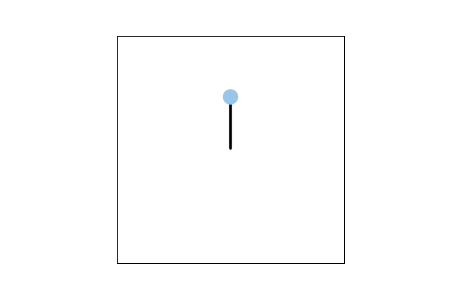

In [13]:
with open('gifs/sample_cont.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

For further safety approaches down below, we need a fail-safe controller. Here we utilise a LQR-controller (see above).<br> The MathPendulumEnv already implements it as part of the so-called safe_action method (here triggered via debugging methods and a using a random initial state within the safe region).

In [ ]:
# Initialise environment
env = gym.make('MathPendulum-v0')
# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, env_safe_action=True, sleep=.1)

# Rollout and save as gif
frames = rollout(env, render=True, rgb_array=True, env_safe_action=True, sleep=0)
anim = animate(frames, dpi=75)
anim.save('gifs/sample_lqr.gif', writer='imagemagick', fps=30)

In [ ]:
with open('gifs/sample_lqr.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**Safety Wrappers**

Every safety wrapper expects to be given the underlying environment and a SafeRegion instance (see above).

Additionally, one needs to the pass following (unbounded) functions, which can either be passed directly or, if already implemented in the underlying environment, as reference via string (further specifications at respective wrappers).

- [Required/Optional] **dynamics_fn**<br>
Given the environment and the agent's action, this function returns the next state (of the variables that should stay in the safe region).
<br>
- [Required/None] **safe_action_fn**<br>
Given the environment, the safe region and the agent's action, this function returns a fail-safe action.
<br>
- [Optional/None] **punishment_fn**<br>
Given the environment, the safe region, the agent's action and the wrapper's action,<br>this function returns a reward that is <ins>added</ins> to the overall reward (i.e. return a negative reward for punishment).
<br>
- [Optional] **transform_action_space_fn**<br>
Given an action, this function returns the action transformed into another action space. We utilise this method to transform a discrete action space (mandatory for masking) to a continuous one (due to our exemplified fail-safe controllers working with continuous actions).<br>
If used, the passed actions to aforementioned functions will already be transformed.<br>
The action space itself can be altered via **alter_action_space**: Optional[gym.Space].
<br>

**SafetyShield**

- [Required] **dynamics_fn** [Required] **safe_action_fn** [Optional] **punishment_fn**<br>
- Alters info s.t. info["shield"] = {"action": action, "action_shield": action_shield (or None), "reward": reward, "punishment": punishment (or None)}.

In [6]:
from sb3_contrib.common.wrappers import SafetyShield

def dynamics_fn(env: gym.Env, action: Union[int, float, np.ndarray]) -> np.ndarray:
    theta, thdot = env.state
    return env.dynamics(theta, thdot, action)


def punishment_fn(env: gym.Env, safe_region: SafeRegion,
                  action: Union[int, float, np.ndarray],
                  action_shield: Union[int, float, np.ndarray]) -> float:
    return -abs(action - action_shield)

# Initialise environment
env = gym.make('MathPendulum-v0')

# Wrap with SafetyShield
env = SafetyShield(
                env=env,
                safe_region=safe_region,
                dynamics_fn=dynamics_fn,
                safe_action_fn="safe_action", # Method already in env (LQR controller)
                punishment_fn=punishment_fn,
                transform_action_space_fn=lambda a:2*(a-7),
                alter_action_space=gym.spaces.Discrete(15))

# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
rollout(env, render=True, rgb_array=False, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_shield.gif', writer='imagemagick', fps=20)

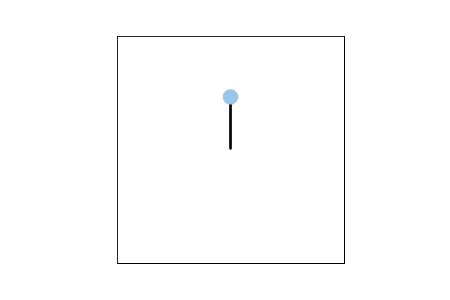

In [45]:
with open('gifs/sample_shield.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**SafetyCBF**

**Note**<br>

The CBF wrapper works by seperating the dynamics into the nominal unactuated dynamics and the nominal actuated dynamics. Thus we introduce new functions,

- **unactuated_dynamics_fn**<br>
Given the environment, this function equals f in the time evolution next_state = f(cur_state)+g(cur_state)*action.

- **actuated_dynamics_fn**<br>
Given the environment, this function equals g in the time evolution next_state = f(cur_state)+g(cur_state)*action.

The wrapper requires either to be given **actuated_dynamics_fn** and either **dynamics_fn** or **unactuated_dynamics_fn**.<br>Again, pass unbounded functions or the respective str.<br>

Additionally, one can pass the **gamma** that influences how much the state is "pushed inwards"<br>(if zero, the barrier condition simplifies to the Lyapunov condition).

- [None] **safe_action_fn** [Optional] **punishment_fn**<br>
- Alters info s.t. info["shield"] = info["cbf"] = {"action": action, "action_bar": action_bar, "reward": reward, "punishment": punishment (or None)}.

In [8]:
#TBD

from sb3_contrib.common.wrappers import SafetyCBF

def actuated_dynamics_fn(env: gym.Env) -> np.ndarray:
    return np.array([(0),(env.dt/(env.m*env.l**2))])

def dynamics_fn(env: gym.Env, action: Union[int, float, np.ndarray]) -> np.ndarray:
    theta, thdot = env.state
    return env.dynamics(theta, thdot, action)


def punishment_fn(env: gym.Env, safe_region: SafeRegion,
                  action: Union[int, float, np.ndarray],
                  action_cbf: Union[int, float, np.ndarray]) -> float:
    return -abs(action_cbf)

# Initialise environment
env = gym.make('MathPendulum-v0')

# Wrap with SafetyCBF
env = SafetyCBF(
                env=env,
                safe_region=safe_region,
                dynamics_fn=dynamics_fn,
                actuated_dynamics_fn=actuated_dynamics_fn,
                #unactuated_dynamics_fn=unactuated_dynamics_fn
                punishment_fn=punishment_fn,
                transform_action_space_fn=lambda a:2*(a-7),
                alter_action_space=gym.spaces.Discrete(15),
                gamma=0.5)

# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
rollout(env, render=True, rgb_array=False, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_cbf.gif', writer='imagemagick', fps=30)

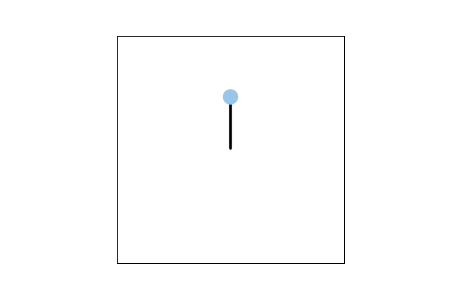

In [22]:
with open('gifs/sample_cbf.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**SafetyMask**
- Support for PPO, A2C
- [Required] **dynamics_fn** [Required] **safe_action_fn** [None] **punishment_fn** (TBD)<br>
- Alters info s.t. info["mask"] = {"action": action, "action_mask": action_mask (or None), "mask": self._last_mask, "reward": reward, "punishment": punishment (or None)}

In [9]:
from sb3_contrib.common.wrappers import SafetyMask

def dynamics_fn(env: gym.Env, action: Union[int, float, np.ndarray]) -> np.ndarray:
    theta, thdot = env.state
    return env.dynamics(theta, thdot, action)


def punishment_fn(env: gym.Env, safe_region: SafeRegion,
                  action: Union[int, float, np.ndarray],
                  action_mask: Union[int, float, np.ndarray]) -> float:
    return -(action_mask ** 2)

# Initialise environment
env = gym.make('MathPendulum-v0')

# Wrap with SafetyMask
env = SafetyMask(
                env=env,
                safe_region=safe_region,
                dynamics_fn=dynamics_fn,
                safe_action_fn="safe_action", # Method already in env (LQR controller)
                punishment_fn=punishment_fn,
                transform_action_space_fn=lambda a:2*(a-7),
                alter_action_space=gym.spaces.Discrete(15))

# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
rollout(env, render=True, rgb_array=False, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_mask.gif', writer='imagemagick', fps=20)

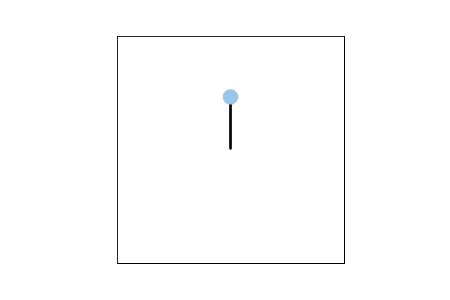

In [47]:
with open('gifs/sample_mask.gif','rb') as f:
    display(Image(data=f.read(), format='png'))